In [1]:
modelPath = "Clickbait"
checkpoint = "cmarkea/distilcamembert-base"   # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base"
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 3                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'                      # 'LCFraction'
removeColumns = ['postText', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.1                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)

Some weights of the model checkpoint at cmarkea/distilcamembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.weight', 'class

In [4]:
import datasets as ds

In [5]:
curated = ds.load_from_disk(dataCuratedPath)

In [21]:
curated.to_pandas()

,postText,id,targetTitle,postTimestamp,targetKeywords,targetDescription,truthMean
0,[UK’s response to modern slavery leaving victi...,858462320779026432,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,1.000000
1,[this is good],858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,0.133333
2,"[The ""forgotten"" Trump roast: Relive his bruta...",858368123753435136,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,0.400000
3,[Meet the happiest #dog in the world!],858323428260139008,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...",0.266667
4,[Tokyo's subway is shut down amid fears over a...,858283602626347008,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...",0.000000
...,...,...,...,...,...,...,...
19533,[Brazil soccer team and pilot's final intervie...,804250183642976256,"NBC News Video See Brazil Soccer Team, Pilot’s...",Thu Dec 01 09:06:00 +0000 2016,,NBC News,0.133333
19534,[😱😱😱😱😱😱😱😱😱😱😱😱😱😱],804156272086020096,Politico Scoop: Eric Trump Killed Two Deer,Thu Dec 01 02:52:50 +0000 2016,Politico Scoop: Eric Trump Killed Two Deer,Politico Scoop: Eric Trump Killed Two Deer,0.066667
19535,[Frenchs Forest high school may have to make w...,804149798651588608,Frenchs Forest high school may relocate to mak...,Thu Dec 01 02:27:07 +0000 2016,"frenchs forest, northern beaches, sydney, rede...",The Forest High School on Sydney's northern be...,0.333333
19536,[Oh Jeff… #bruh],804134698729385984,Los Angeles Rams Jeff Fisher May Think Danny W...,Thu Dec 01 01:27:06 +0000 2016,"Humor, Football, NFL, NFC West, Los Angeles Ra...","Los Angeles Rams news, rumors, scores, schedul...",0.733333


In [6]:
longueur= len(curated)

In [7]:
trie=sorted(curated[LCfraction])

In [8]:
import matplotlib.pyplot as plt

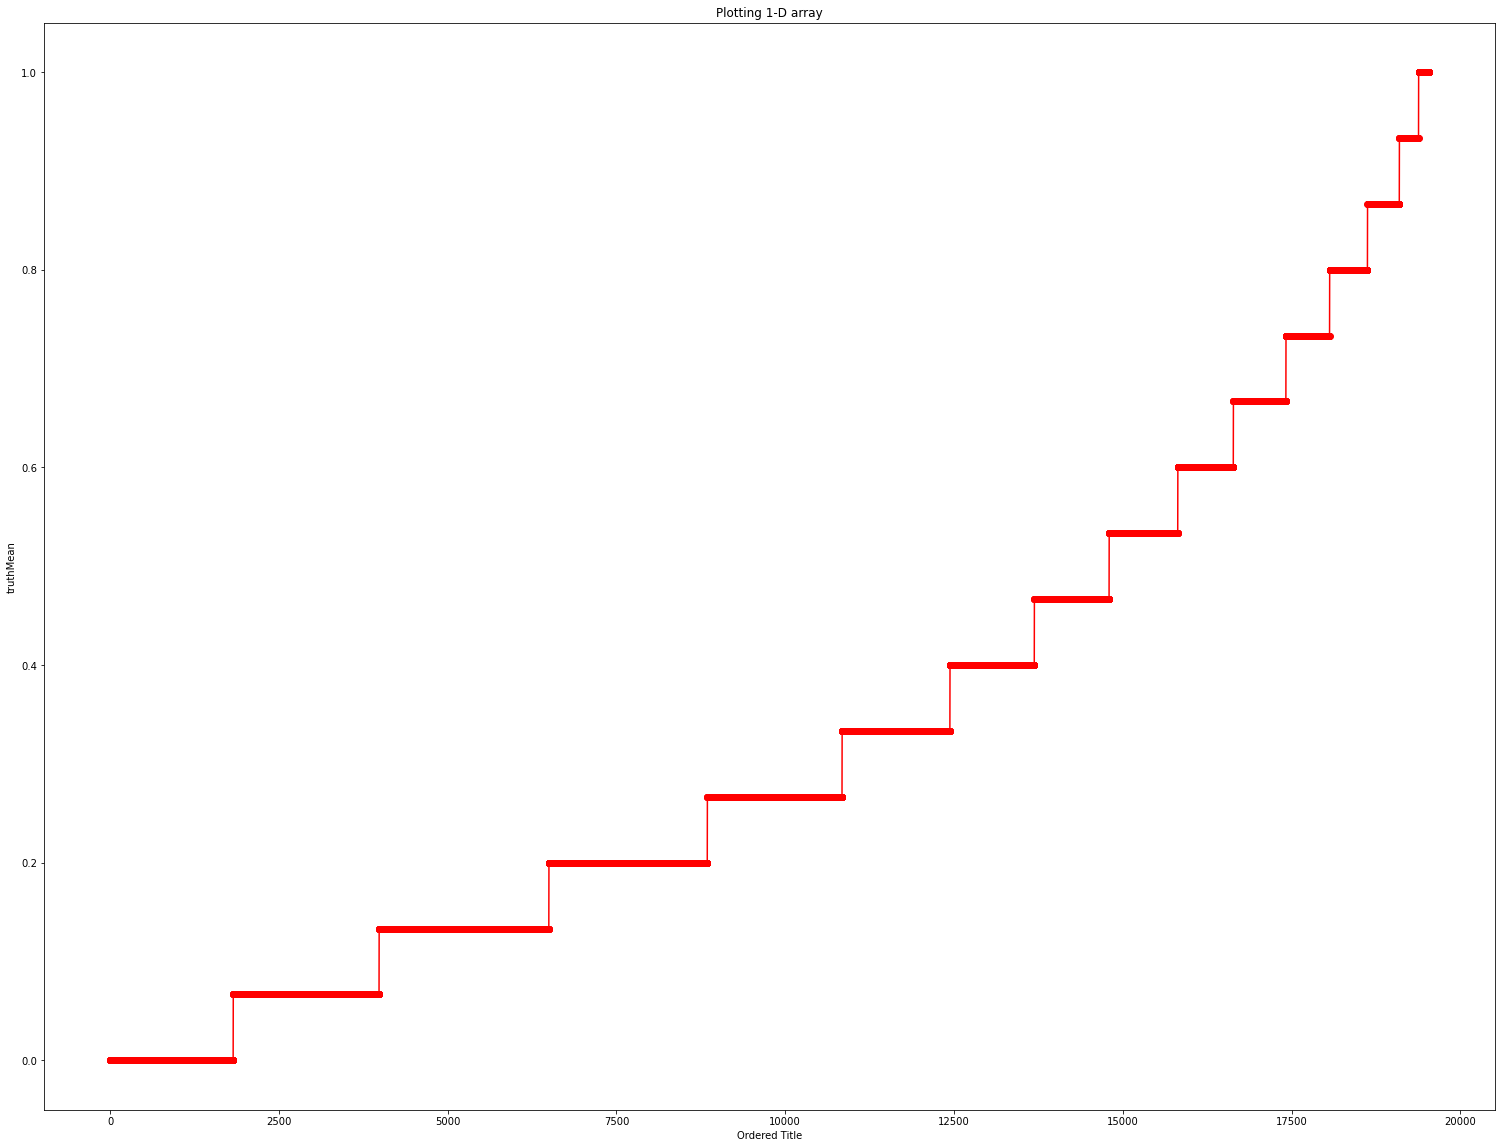

In [9]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")

In [10]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.199999999979999, 0.399999999979999]

In [22]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample['targetTitle'],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            #padding=True,
            #truncation=True,
            #max_length=30
            )
    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
        
    # print( fraction, tokenized_sample["labels"], sample['postText'])
    
    return tokenized_sample

In [23]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/19538 [00:00<?, ?ex/s]

In [24]:
tokenized_curated

Dataset({
    features: ['postText', 'id', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'truthMean', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 19538
})

In [25]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [26]:
tokenized_curated4 = tokenized_curated3

In [27]:
tokenized_curated4.set_format("torch")

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 8,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [31]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [32]:
# faire la boucle avec le trainer pytorch
%pdb
trainer.train()

***** Running training *****
  Num examples = 17584
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17584


Automatic pdb calling has been turned ON


Step,Training Loss,Validation Loss,Matthews Correlation
50,No log,1.135489,0.004639
100,No log,1.101393,-0.006503
150,No log,1.103349,0.034989
200,No log,1.139895,0.000000
250,No log,1.153777,0.000000
300,No log,1.108603,0.000000
350,No log,1.105563,0.000782
400,No log,1.099821,-0.001729
450,No log,1.115157,0.000000
500,1.128300,1.122223,0.000000


***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Clickbait\check

TrainOutput(global_step=650, training_loss=1.1263484778771033, metrics={'train_runtime': 93.9531, 'train_samples_per_second': 1497.257, 'train_steps_per_second': 187.157, 'total_flos': 53499154893552.0, 'train_loss': 1.1263484778771033, 'epoch': 0.3})